# Velocities

Barotropic velocities are determined from ADCP data, the ADCP measurement are aggregated and averaged over the period of the CTD cast. Then, the adcp velocities are averaged over a certain depth. The first figure shows the barotropic velocities determined from the upper 100 meter of the water column with in circles the associated standard deviation from the mean. The second figure shows the barotropic velocities determined from the mixed layer depth to the maximum depth the ADCP reached, again the standard deviation from the mean is shown in circles.

In [1]:
%run ../_setup.py

import math
import numpy as np
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

from netCDF4 import Dataset, num2date

from gsw import sigma0

from OceanPy.interpolation import OI
from OceanPy.stability import mixed_layer_depth

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook


## average ADCP velocities (at CTD locations) and determine standard deviation over first 100 dbar

In [2]:
input_file_adcp = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_adcp_ctd.nc')
input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')

adcp = Dataset(input_file_adcp)
ctd = Dataset(input_file_ctd)

nst = ctd.dimensions['profile'].size

# find index of pressure closest to predefined pressure level
plevel = 100
pressure = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), 
                       adcp.dimensions['plevel'].size)
ip = (np.abs(pressure-plevel)).argmin()

# calculate mean of velocities from surface to pressure level
utdmean = np.nanmean(adcp['u_ctd'][:, slice(0, ip)], axis=1)
vtdmean = np.nanmean(adcp['v_ctd'][:, slice(0, ip)], axis=1)

# calculate magnitude of vectors and calculate standard deviation
vmag = np.sqrt(adcp['u_ctd'][:]**2 + adcp['v_ctd'][:]**2)
vmagmean = np.nanmean([vmag[ist, slice(0, ip)] for ist in range(nst)], axis=1)
vmagstd = np.nanstd([vmag[ist, slice(0, ip)] for ist in range(nst)], axis=1)


## determine dynamic height contours (linear interpolation) between 1500-1000 dbar

In [3]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p']):
    pressure_levels[p] = ip

# define reference and interest level 
p_ref = 1500
p_int = 1000

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# find finite values
idx = np.isfinite(D[2:])

# interpolate linearly dynamic height contours on grid
lon, lat = ctd['lon'][2:, 0][idx], ctd['lat'][2:, 0][idx]
nx, ny = 20, 20
xi = np.linspace(lon.min(), lon.max(), nx)
yi = np.linspace(lat.min(), lat.max(), ny)
xx, yy = np.meshgrid(xi, yi)
Dgrd = griddata((lon, lat), D[2:][idx], (xx, yy), method='linear')

# Vgrd = griddata((adcp['lon_ctd'][2:], adcp['lat_ctd'][2:]), vmagmean[2,:], (xx, yy), method='linear')


## plot velocity vectors with standard deviation circles on top of dynamic height contours

((137.5, 144), (-52.5, -48))

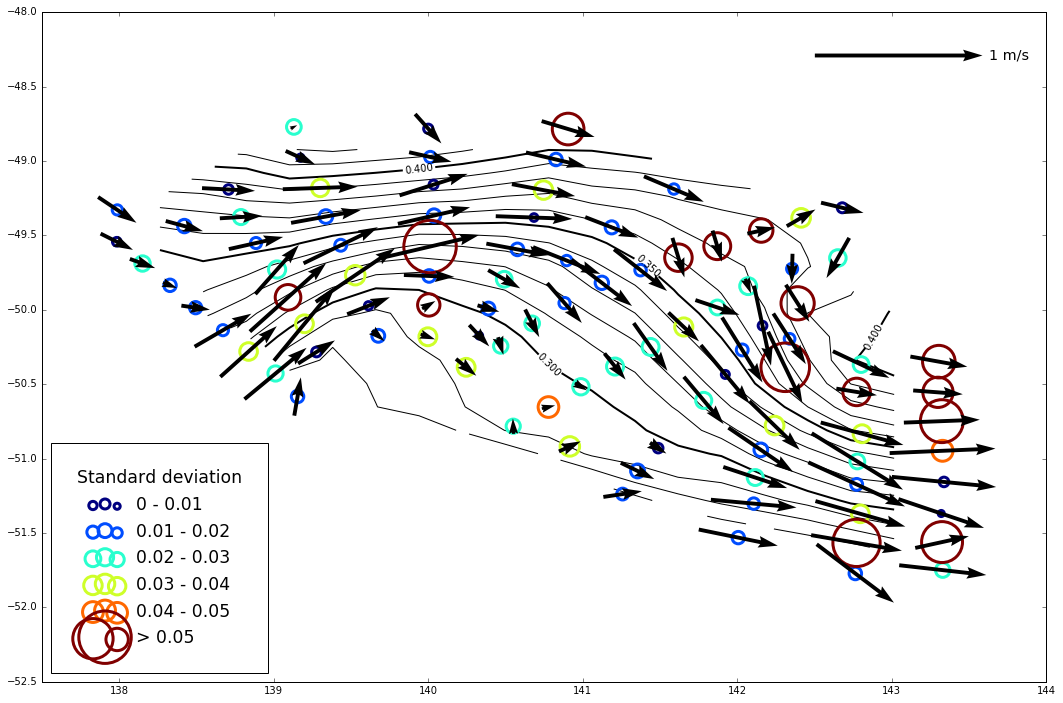

In [4]:
fig, ax = plt.subplots(figsize=(18, 12))

# plot dynamic height contours
step = 0.01
xmin, xmax = math.floor(np.nanmin(Dgrd)*100)/100, math.ceil(np.nanmax(Dgrd)*100)/100
nsteps = int((xmax - xmin) / step) + 2
bounds = np.linspace(xmin, xmax, nsteps)

ct = ax.contour(xx, yy, Dgrd, bounds, colors='k', zorder=1)

for ib, b in enumerate(bounds):
    if b in bounds[4::5]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=2)
ax.clabel(ct, bounds[4::5], inline=1, fontsize=10)


# plot quiver plot
Q = ax.quiver(adcp['lon_ctd'][2:], adcp['lat_ctd'][2:], utdmean[2:], vtdmean[2:], 
              pivot='mid', units='inches', width=0.003*18, zorder=3)
qk = plt.quiverkey(Q, 0.85, 0.85, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'x-large'})

# # plot contour of veocity magnitude
# conf = plt.contourf(xx, yy, Vgrd, zorder=0)

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
colors = cm.jet(np.linspace(0, 1, len(std_bins)))
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (vmagstd[2:] > std_bins[i])
        label = '> %s' % (std_bins[i])
    else:
        criteria = (vmagstd[2:] > std_bins[i]) & (vmagstd[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(adcp['lon_ctd'][2:][criteria], adcp['lat_ctd'][2:][criteria], s=vmagstd[2:][criteria]*1e4, 
               label=label, color=colors[i], facecolors='none', linewidth=3, zorder=2)
legend = ax.legend(title='Standard deviation', borderpad=1.5, fontsize='xx-large', loc=3)
legend.get_title().set_fontsize('xx-large')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])


## average ADCP velocities from surface to mixed-layer pressure

In [5]:
smooth = True
imld = []
for ist in range(nst):
    
    # read variables
    sig0 = ctd['sigma0'][ist,]
    pt = ctd['pt'][ist,]
    z = ctd['z'][ist,]

    # determine index of mixed layer depth 
    imld_tdd = mixed_layer_depth(z, sig0=sig0, pt=pt, smooth=smooth)[0]
    imld.append(imld_tdd)
    
# construct adcp pressure levels
padcp = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), adcp.dimensions['plevel'].size)

# find reference depth
ref = 20
iref, ref_dep = min(enumerate(padcp), key=lambda x: abs(x[1] - ref))
print('reference depth: %s' %ref_dep)

# find pressure of mixed layer depth
pmld = [ctd['p'][i] for i in imld]
imldadcp = [(np.abs(padcp - p)).argmin() for p in pmld]

# calculate mean of velocities from surface to pressure level
utdmean = np.array([np.nanmean(adcp['u_ctd'][ist, slice(iref, imldadcp[ist])]) for ist in range(nst)])
vtdmean = np.array([np.nanmean(adcp['v_ctd'][ist, slice(iref, imldadcp[ist])]) for ist in range(nst)])

# calculate magnitude of vectors and calculate standard deviation
vmagmean = np.array([np.nanmean(vmag[ist, slice(iref, imldadcp[ist])]) for ist in range(nst)])
vmagstd = np.array([np.nanstd(vmag[ist, slice(iref, imldadcp[ist])]) for ist in range(nst) 
                   if not all(vmag[ist, slice(iref, imldadcp[ist])].mask)])

reference depth: 16.8


((137.5, 144), (-52.5, -48))

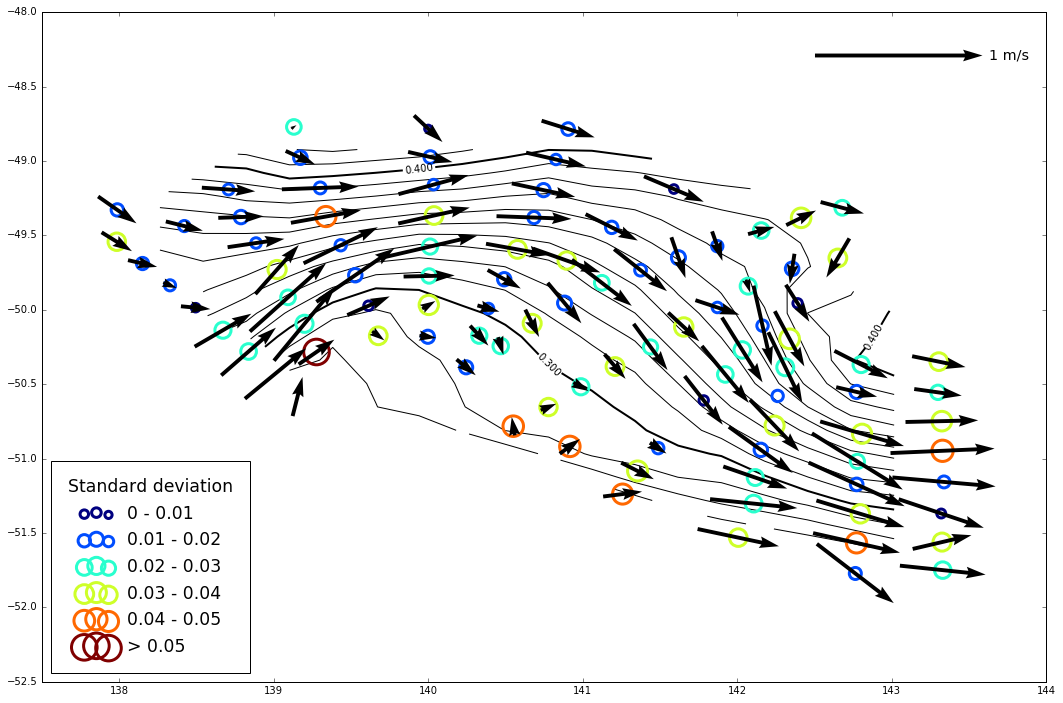

In [6]:
# PLOT

fig, ax = plt.subplots(figsize=(18, 12))

# plot dynamic height contours
ct = ax.contour(xx, yy, Dgrd, bounds, colors='k', zorder=-1)

for ib, b in enumerate(bounds):
    if b in bounds[4::10]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=2)
ax.clabel(ct, bounds[4::10], inline=1, fontsize=10)

# plot quiver plot
Q = ax.quiver(adcp['lon_ctd'][2:], adcp['lat_ctd'][2:], utdmean[2:], vtdmean[2:], 
              pivot='mid', units='inches', width=0.003*18, zorder=2)
qk = plt.quiverkey(Q, 0.85, 0.85, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'x-large'})

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (vmagstd[2:] > std_bins[i])
        label = '> %s' % (std_bins[i])
    else:
        criteria = (vmagstd[2:] > std_bins[i]) & (vmagstd[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(adcp['lon_ctd'][2:][criteria], adcp['lat_ctd'][2:][criteria], s=vmagstd[2:][criteria]*1e4, 
               label=label, color=colors[i], facecolors='none', linewidth=3, zorder=1)
legend = ax.legend(title='Standard deviation', borderpad=1, fontsize='xx-large', loc=3)
legend.get_title().set_fontsize('xx-large')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])


## create geostrophic velocity background field from sea surface height (SSH)

In [7]:
input_file_ssh = os.path.join(datadir, 'external', 'ssh', 'SSH_OceanCurrent_137.5_-52_144_-48.5_199803.nc')
ssh = Dataset(input_file_ssh)

lon, lat = adcp['lon_ctd'][2:], adcp['lat_ctd'][2:]
loni, lati = ssh['LONGITUDE'][:], ssh['LATITUDE'][:]

# monthly mean ssh
ummean = np.mean(ssh['UCUR'][:], axis=0)
vmmean = np.mean(ssh['VCUR'][:], axis=0)

# monthly mean geostrophic velocity magnitude
V = np.ma.masked_array([np.sqrt(ssh['UCUR'][t,::]**2 + ssh['UCUR'][t,::]**2) 
                        for t in range(ssh.dimensions['TIME'].size)])
Vmmean = np.mean(V, axis=0)

# optimal interpolation of ADCP velocities with SSH geostrophic velocities as background field
mask = np.ma.masked_invalid(utdmean[2:]).mask
xx, yy, u_b, u_a = OI(lon[~mask], lat[~mask], utdmean[2:][~mask],
                      Lx=(lon.max() - lon.min())/12, Ly=(lat.max() - lat.min())/14,
                      xx=loni, yy=lati, bg_fld=ummean)
v_b, v_a = OI(lon[~mask], lat[~mask], vtdmean[2:][~mask],
              Lx=(lon.max() - lon.min())/12, Ly=(lat.max() - lat.min())/14,
              xx=loni, yy=lati, bg_fld=vmmean)[2:]


### velocity magnitude

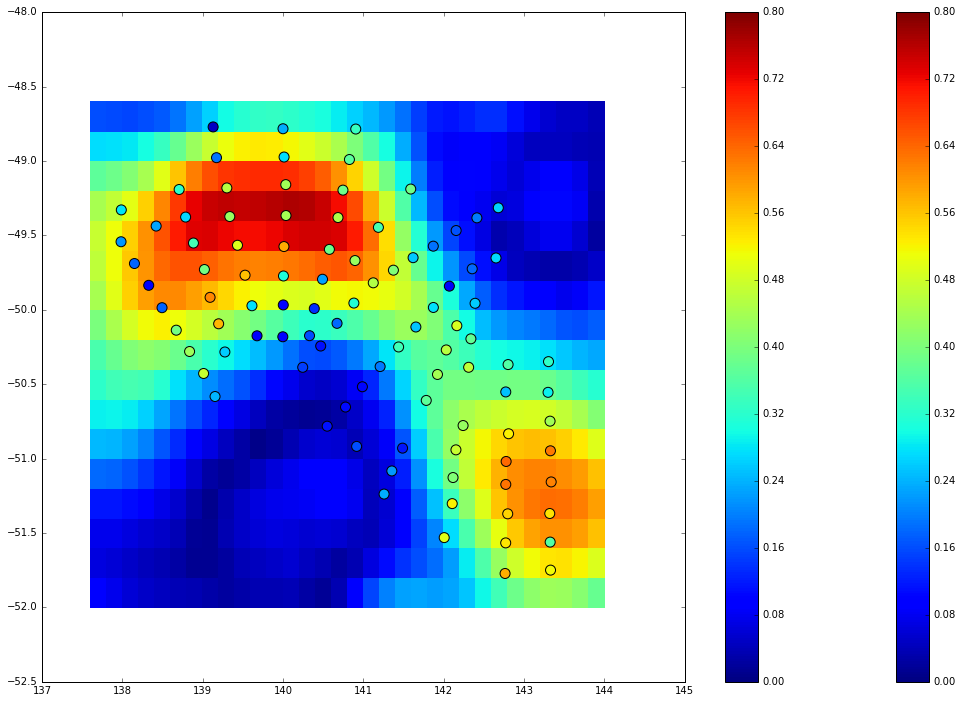

In [10]:
fig, ax = plt.subplots(figsize=(18, 12))
vmin, vmax = 0, 0.8
pcol = ax.pcolor(xx, yy, Vmmean.data, vmin=vmin, vmax=vmax)
plt.colorbar(pcol)
scat = ax.scatter(lon, lat, c=vmagmean[2:].data, s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)

### background field u-component

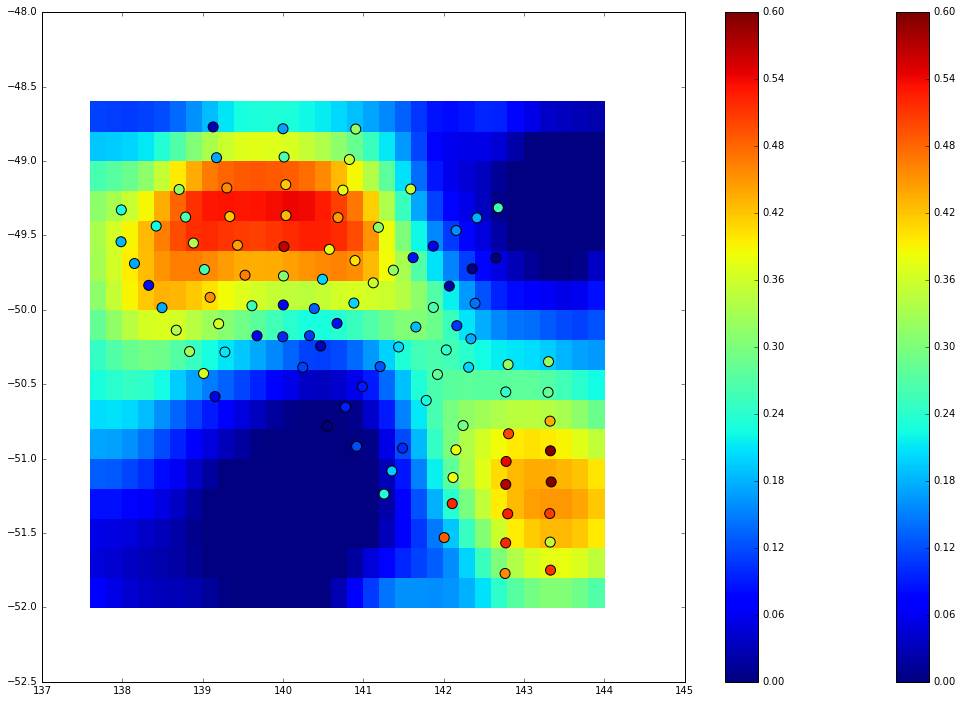

In [9]:
fig, ax = plt.subplots(figsize=(18, 12))
vmin, vmax = 0, 0.6
pcol = ax.pcolor(xx, yy, u_b, vmin=vmin, vmax=vmax)
plt.colorbar(pcol)
scat = ax.scatter(lon, lat, c=utdmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)

### analysis field u-component

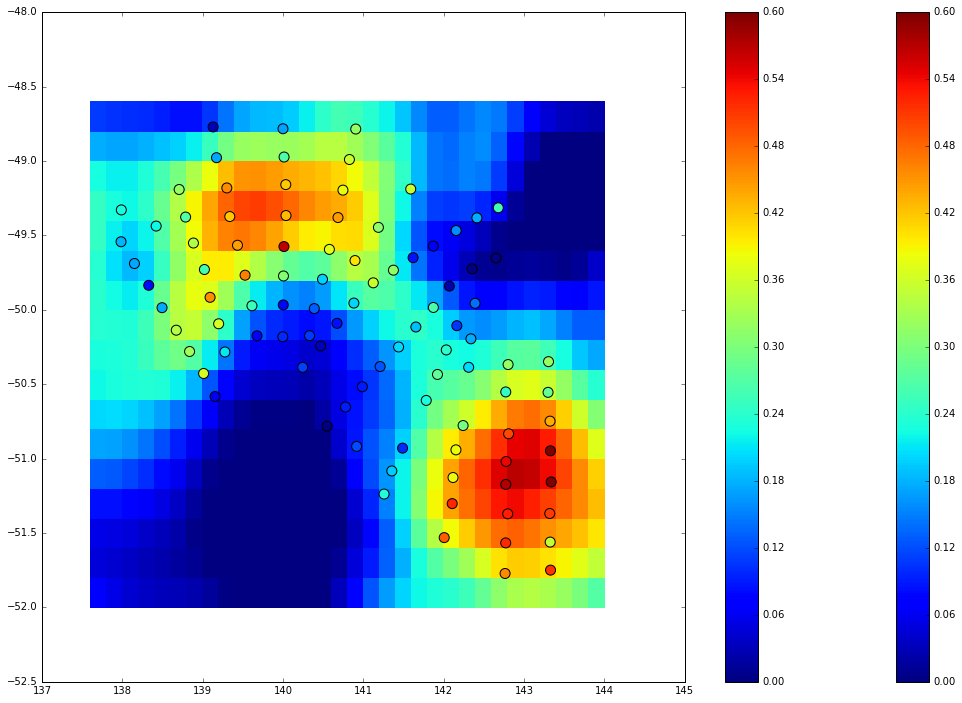

In [10]:
fig, ax = plt.subplots(figsize=(18, 12))
pcol = ax.pcolor(xx, yy, u_a, vmin=vmin, vmax=vmax)
plt.colorbar(pcol)
scat = ax.scatter(lon, lat, c=utdmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)

### background field v-component

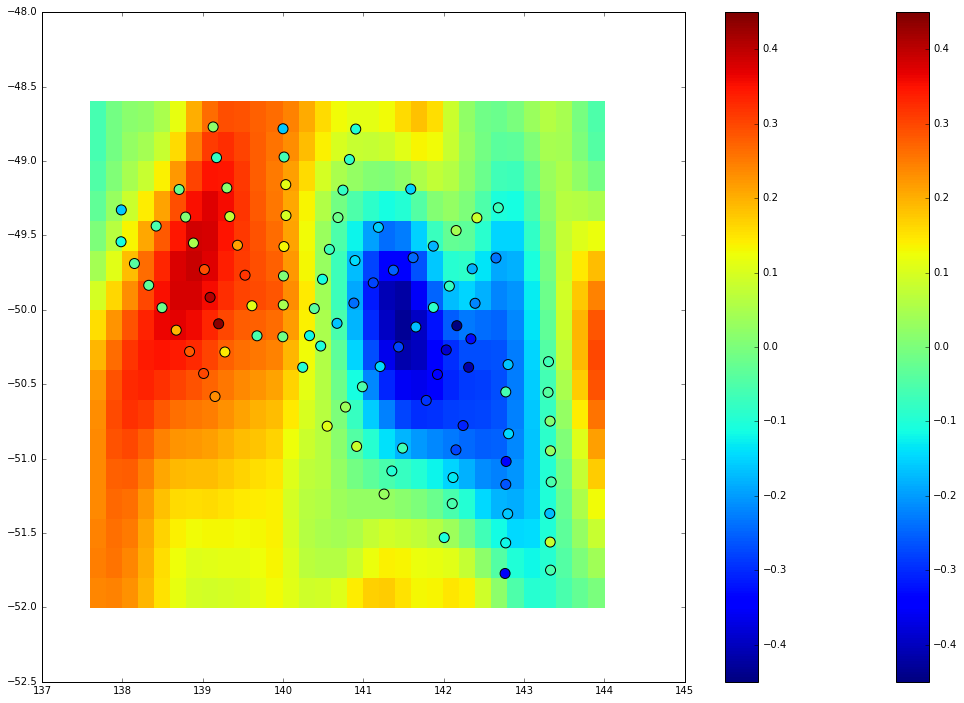

In [11]:
vmin, vmax = -0.45, 0.45
fig, ax = plt.subplots(figsize=(18, 12))
pcol = ax.pcolor(xx, yy, v_b, vmin=vmin, vmax=vmax)
plt.colorbar(pcol)
scat = ax.scatter(lon, lat, c=vtdmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)

### analysis field v-component

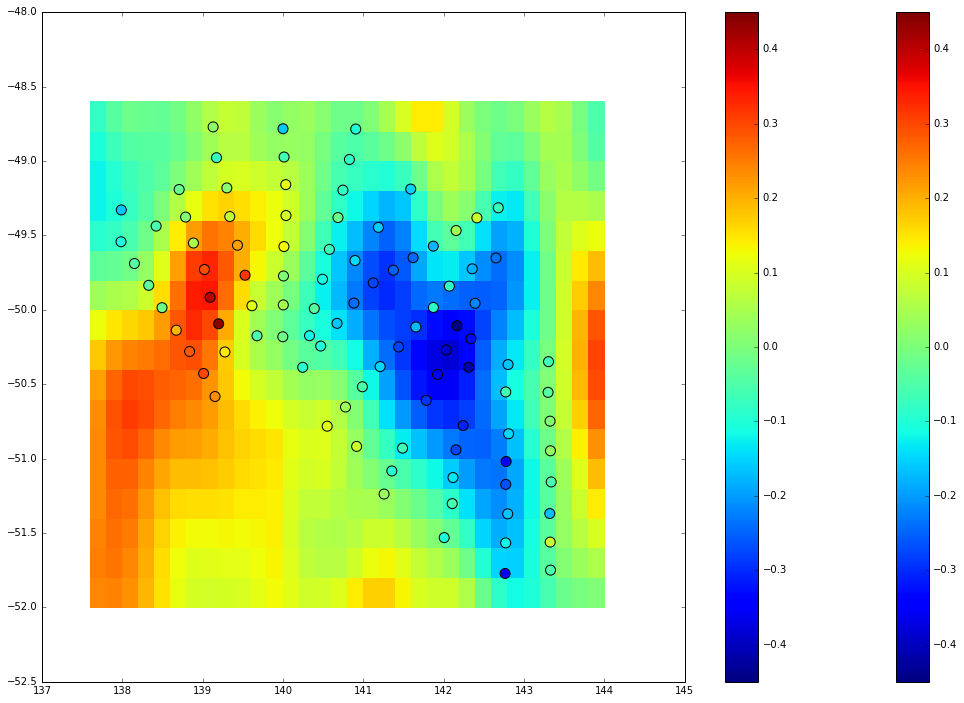

In [12]:
fig, ax = plt.subplots(figsize=(18, 12))
pcol = ax.pcolor(xx, yy, v_a, vmin=vmin, vmax=vmax)
plt.colorbar(pcol)
scat = ax.scatter(lon, lat, c=vtdmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat)